## Additional trainings
In this notebook we will compare different pre-trained networks for specific
tests, namely:
* Impact of the dataset size
* Impact of the learning rate
* Impact of a heavier model
* Impact of the global residual connection

The procedure is always the same, i.e. loading pre-trained networks and plot
histories as well as predict the reconstructed images.

Let's first import and load everything that will be need for these detailed
comparisons.


In [3]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.plot import plot_image_sequences, plot_histories
from models import load_pretrained_model
from utils.dataset import load_dataset, get_dataset_axes
from utils.signal import convert_to_bmode

In [4]:
# Paths
base_dir = os.path.join('/floyd', 'input', 'dlssus')
data_dir = os.path.join(base_dir, 'datasets')
train_dir = os.path.join(base_dir, 'trainings')
testset_path = os.path.join(data_dir, 'dlssus-rf-testset.h5')

# Load test set
test_lq, test_hq = load_dataset(path=testset_path)

# Load image axes
image_axes = get_dataset_axes(path=testset_path)

# Convert test set to B-mode
# Convert to B-mode before plotting (we need to squeeze the dimensions now)
test_bm_lq = convert_to_bmode(test_lq)
test_bm_hq = convert_to_bmode(test_hq)

# Expand last dimension for inference (H, W, C)
test_lq_exp = test_lq[..., np.newaxis]

# Plot settings
data_range = (-50, 30)  # data-range in dB
name_seq = ('LQ', 'HQ', 'REC')


### Impact of the training set size
We compare four different training set sizes, i.e. 50, 250, 1000, 6000 and
11900, on the small version of the adapted UNet architecture.

Let's first load every pre-trained model.

In [5]:
# Load pre-trained models
model1_name = 'usunet_res_small_rf_sn00050_lr0.000400_it0200000'
model1_path = os.path.join(train_dir, model1_name)
model2_name = 'usunet_res_small_rf_sn00250_lr0.000400_it0200000'
model2_path = os.path.join(train_dir, model2_name)
model3_name = 'usunet_res_small_rf_sn06000_lr0.000400_it0200000'
model3_path = os.path.join(train_dir, model3_name)
model4_name = 'usunet_res_small_rf_sn11900_lr0.000400_it0200000'
model4_path = os.path.join(train_dir, model4_name)

model1, model1_hist, train_size1 = load_pretrained_model(filepath=model1_path)
model2, model2_hist, train_size2 = load_pretrained_model(filepath=model2_path)
model3, model3_hist, train_size3 = load_pretrained_model(filepath=model3_path)
model4, model4_hist, train_size4 = load_pretrained_model(filepath=model4_path)

We can now plot the histories of each mode within the same figure.


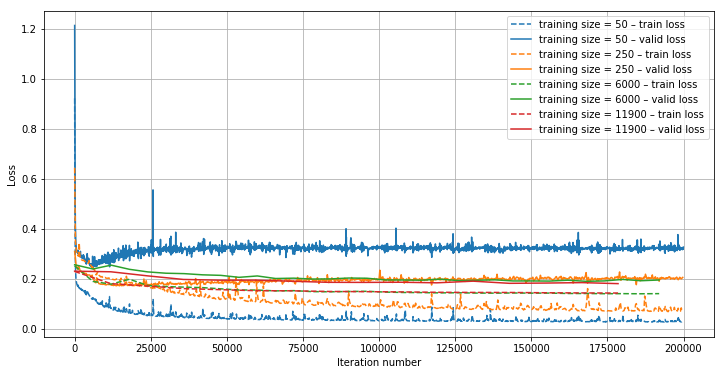

In [6]:
# Plot histories
hist_list1 = [model1_hist, model2_hist, model3_hist, model4_hist]
train_sizes = [train_size1, train_size2, train_size3, train_size4]
names = ['training size = {:d}'.format(ts) for ts in train_sizes]
plot_histories(hist_list1, names=names, train_sizes=train_sizes)

Ok, there are a lot of curves but let's go step by step.
First, only analyze the training loss curves (dashed).
What can you observe?

Clearly, the more data you use the worse it gets which may be
counter-intuitive at first.
However, if we again think about over-fitting it seems clear that it is easier
to learn a few images "by heart" than having to learn a lot of them.

If we now look at the validation loss curves (not dashed)
we can observe the inverse behaviour, i.e. more training data leads to a
better behaviour.
This is because whatever is learned by the network is much more meaningful
and generalizable to samples that are not inside the training set.

**So, you should take two messages from these curves:**
* Validation is key
* More is the optimal solution against over-fitting

Now let's have a look at the predicted images of the best network in this
comparison


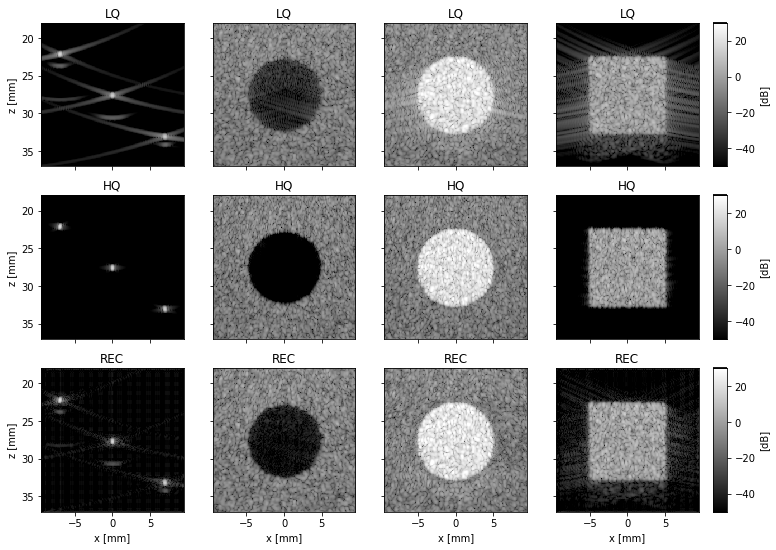

In [7]:
# Apply network on LQ test images
test_rc1 = model4.predict(test_lq_exp)

# Squeeze last dimension and convert to B-mode for plotting
test_rc1 = test_rc1.squeeze()
test_bm_rc1 = convert_to_bmode(test_rc1)

# Plot
test_seq1 = [test_bm_lq, test_bm_hq, test_bm_rc1]
plot_image_sequences(
    image_seq=test_seq1, name_seq=name_seq, image_axes=image_axes,
    data_range=data_range, colorbar=True
)


Looking at the test set, the quality seems better, but we still introduce
some unwanted artifacts.

At least these artifacts doesn't come from over-fitting, but most probably
because the orangeuced version of the adapted UNet is actually not powerful
enough to accurately tackle this problem.


### Impact of the learning rate
In this test we will only analyze the history curves for 3 different learning
rates applied to the small network.

In [8]:
# Load pre-trained models
model5_name = 'usunet_res_small_rf_sn11900_lr0.010000_it0200000'
model5_path = os.path.join(train_dir, model5_name)
model6_name = 'usunet_res_small_rf_sn11900_lr0.000400_it0200000'
model6_path = os.path.join(train_dir, model6_name)
model7_name = 'usunet_res_small_rf_sn11900_lr0.000010_it0200000'
model7_path = os.path.join(train_dir, model7_name)

model5, model5_hist, train_size5 = load_pretrained_model(filepath=model5_path)
model6, model6_hist, train_size6 = load_pretrained_model(filepath=model6_path)
model7, model7_hist, train_size7 = load_pretrained_model(filepath=model7_path)


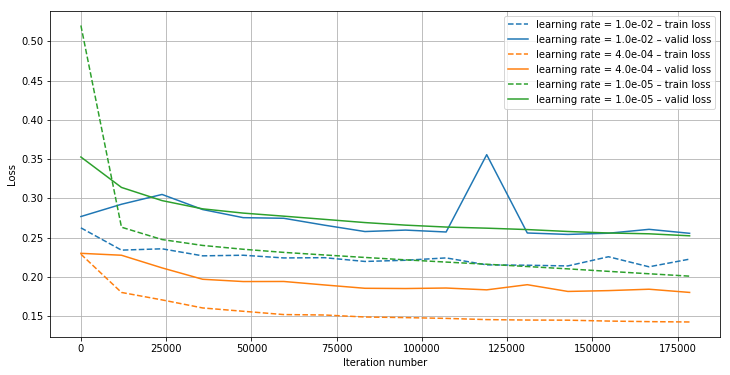

In [9]:
# Plot histories
hist_list2 = [model5_hist, model6_hist, model7_hist]
learning_rates = [1e-2, 4e-4, 1e-5]
train_sizes2 = [train_size5, train_size6, train_size7]
names2 = ['learning rate = {:.1e}'.format(lr) for lr in learning_rates]
plot_histories(hist_list2, names=names2, train_sizes=train_sizes2)

Through the training and validation curves shown in the figure above we can
see an extreme example of wrong learning rate choices.

If your learning rate is chosen too high (blue curves), the training will
at first be very quick but than constantly overshoot and thus the network
will not converge.

If the learning rate is chosen too small (green) it will take the network
a very long time to converge properly.
So best is to choose your learning rate somewhere in-between (orange) :).


### Impact of a heavier model
Now we try with a heavier model (i.e. full model) with a properly set
learning rate and display the predicted images.


In [10]:
# Load pre-trained models
model_full = 'usunet_res_full_rf_sn11900_lr0.000050_it0400000'
model_full_path = os.path.join(train_dir, model_full)
model_full, model_full_hist, train_size_full = load_pretrained_model(
    filepath=model_full_path
)

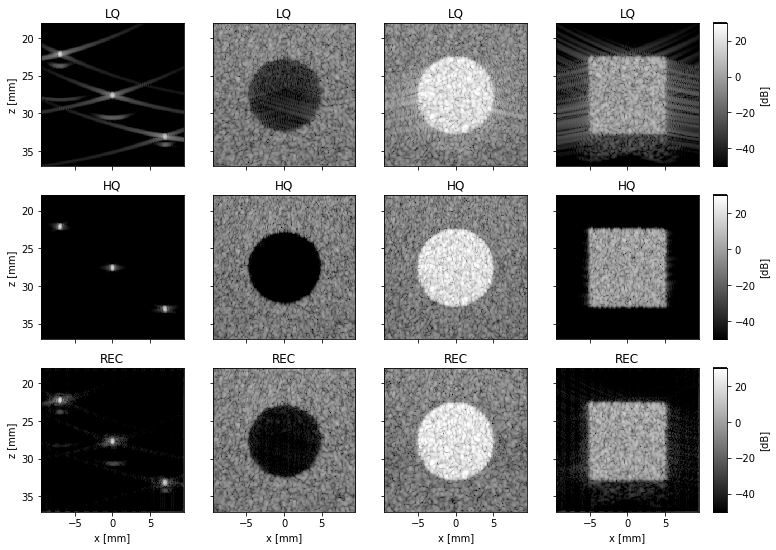

In [11]:
# Apply network on LQ test images
test_rc_full = model_full.predict(test_lq_exp)

# Squeeze last dimension and convert to B-mode for plotting
test_rc_full = test_rc_full.squeeze()
test_bm_rc_full = convert_to_bmode(test_rc_full)

# Plot
test_seq_full = [test_bm_lq, test_bm_hq, test_bm_rc_full]
plot_image_sequences(
    image_seq=test_seq_full, name_seq=name_seq, image_axes=image_axes,
    data_range=data_range, colorbar=True
)

Wow, these test images already seem much better, so our approach does not
seem too bad, it may even have potential.

We can clearly see that the original artifacts have been reduced drastically
and only a few artifacts have been introduced.


### Impact of the global residual connection
We will look at the training and validation curves with and without
residual connection.


In [12]:
model_nores = 'usunet_nores_full_rf_sn11900_lr0.000050_it0400000'
model_nores_path = os.path.join(train_dir, model_nores)
model_full, model_nores_hist, train_size_nores = load_pretrained_model(
    filepath=model_nores_path
)


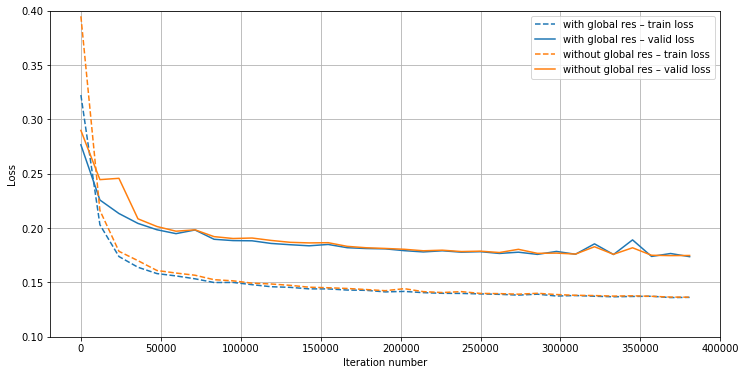

In [13]:
# Plot histories
hist_list3 = [model_full_hist, model_nores_hist]
train_sizes3 = [train_size_full, train_size_nores]
names3 = ['with global res', 'without global res']
plot_histories(hist_list3, names=names3, train_sizes=train_sizes3)
plt.ylim(0.1, 0.4)
plt.show()


We can see that the difference is extremely subtle in this case.
It seems to help converge a bit faster (at least at the begining).

However, the performance increase is not as high as one may have expected,
why do you think that is?

**Hint:** isn't the UNet architecture, without this additional global residual
connection already some "residual" with the intrinsic skip connections? 


### Optional last question/exercise: signal domain

A question you may ask yourself is why did we decided to train our networks
on RF images instead of B-mode images (recall the data exploration).

Do you think that the network performances would be better if trained on
B-mode images?

You can try by yourself to load a pre-trained network on B-mode images,
named `usunet_res_full_bm_sn11900_lr0.000050_it0400000`, and predict the
reconstructed image by using the plot utilities.

**Note:** Do not forget to feed the B-moide images instead of RF images
to the model.


### Just a bit more reading in the [conclusion][next] and then, boat time :)!

[next]: dlssus_conclusion.ipynb
